Output Counts proportional to ATIME

In [9]:
from ctypes import *
import time
from sys import path
import sys
from os import sep
import numpy as np
import matplotlib.pyplot as plt

if sys.platform.startswith("win"):
    dwf = cdll.dwf
    constants_path = "C:" + sep + "Program Files (x86)" + sep + "Digilent" + sep + "WaveFormsSDK" + sep + "samples" + sep + "py"
elif sys.platform.startswith("darwin"):
    dwf = cdll.LoadLibrary("/Library/Frameworks/dwf.framework/dwf")
    constants_path = "/Applications/WaveForms.app/Contents/Resources/SDK/samples/py"
else:
    dwf = cdll.LoadLibrary("libdwf.so")
    constants_path = "/usr/share/digilent/waveforms/samples/py"

path.append(constants_path)
import dwfconstants as constants

In [2]:
dwf.FDwfDeviceCloseAll()
filter_flags = c_int(constants.enumfilterType.value | constants.enumfilterUSB.value)
device_count = c_int()
dwf.FDwfEnum(filter_flags, byref(device_count))

hdwf = c_int()
dwf.FDwfDeviceOpen(c_int(-1), byref(hdwf))
if hdwf.value == 0:
    raise RuntimeError("Failed to open device.")
print(hdwf.value)

dwf.FDwfAnalogIOReset(hdwf)
dwf.FDwfAnalogIOChannelNodeSet(hdwf, c_int(0), c_int(1), c_double(3.0)) #setting VDD = 3V
dwf.FDwfAnalogIOChannelNodeSet(hdwf, c_int(0), c_int(0), c_double(1))
dwf.FDwfAnalogIOEnableSet(hdwf, c_int(1))
time.sleep(0.5)

vpos = c_double()
dwf.FDwfAnalogIOStatus(hdwf)
dwf.FDwfAnalogIOChannelNodeStatus(hdwf, c_int(0), c_int(1), byref(vpos))
print(f"Power: +{vpos.value:.2f}V")

1
Power: +3.01V


In [3]:
DEVICE_ADDR = 0x52
ENABLE_REG = 0x80
ATIME_REG = 0x81
CONTROL_REG = 0x8F
CDATAL_REG = 0x94
CDATAH_REG = 0x95
RDATAL_REG = 0x96
RDATAH_REG = 0x97
GDATAL_REG = 0x98
GDATAH_REG = 0x99
BDATAL_REG = 0x9A
BDATAH_REG = 0x9B

def write_register(reg, value):
    iNak = c_int()
    rgTX = (c_ubyte * 2)(reg, value)
    dwf.FDwfDigitalI2cWrite(hdwf, c_int(DEVICE_ADDR), rgTX, c_int(2), byref(iNak))
    return iNak.value == 0

def read_register(reg):
    iNak = c_int()
    rgTX = (c_ubyte * 1)(reg)
    dwf.FDwfDigitalI2cWrite(hdwf, c_int(DEVICE_ADDR), rgTX, c_int(1), byref(iNak))
    if iNak.value == 0:
        rgRX = (c_ubyte * 1)()
        dwf.FDwfDigitalI2cRead(hdwf, c_int(DEVICE_ADDR), rgRX, c_int(1), byref(iNak))
        if iNak.value == 0:
            return rgRX[0]
    return None

dwf.FDwfDigitalI2cRateSet(hdwf, c_double(100e3))
dwf.FDwfDigitalI2cSclSet(hdwf, c_int(0))
dwf.FDwfDigitalI2cSdaSet(hdwf, c_int(1))
iNak = c_int()
dwf.FDwfDigitalI2cClear(hdwf, byref(iNak))

1

In [4]:
write_register(ENABLE_REG, 0x01) #Power on / PON = 1
time.sleep(0.01)
write_register(ENABLE_REG, 0x03) #Now, also RGBC enable / PON = 1, AEN = 1
write_register(ATIME_REG, 0xF6) #To run for 24ms, upto a max count of 10,240
write_register(CONTROL_REG, 0x02) #Setting AGAIN=16

True

In [5]:
#Function to test the sensor output
def read_colors():
    time.sleep(0.1)
    
    clear_low = read_register(CDATAL_REG)
    clear_high = read_register(CDATAH_REG)
    red_low = read_register(RDATAL_REG)
    red_high = read_register(RDATAH_REG)
    green_low = read_register(GDATAL_REG)
    green_high = read_register(GDATAH_REG)
    blue_low = read_register(BDATAL_REG)
    blue_high = read_register(BDATAH_REG)
    
    if all(val is not None for val in [clear_low, clear_high, red_low, red_high, green_low, green_high, blue_low, blue_high]):
        clear = (clear_high << 8) | clear_low
        red = (red_high << 8) | red_low
        green = (green_high << 8) | green_low
        blue = (blue_high << 8) | blue_low
        return {'clear': clear, 'red': red, 'green': green, 'blue': blue}
    return None

In [12]:
def cleanup():
    dwf.FDwfDeviceClose(hdwf)

In [14]:
cleanup()
#call it everytime after work is done

In [7]:
write_register(CONTROL_REG,3)
for i in range(256):
    atime_val = 255-i
    write_register(ATIME_REG,atime_val)
    colors = read_colors()

    # Calculating sleep time for python
    needed_time = (256 - atime_val) * 0.0024 
    time.sleep(needed_time)

    print(f"ATIME: {255-i}, Clear: {colors['clear']}, R: {colors['red']}, G: {colors['green']}, B: {colors['blue']}")

ATIME: 255, Clear: 982, R: 277, G: 399, B: 308
ATIME: 254, Clear: 1975, R: 528, G: 774, B: 685
ATIME: 253, Clear: 2804, R: 830, G: 1165, B: 979
ATIME: 252, Clear: 3814, R: 1108, G: 1558, B: 1291
ATIME: 251, Clear: 4730, R: 1383, G: 1975, B: 1629
ATIME: 250, Clear: 5625, R: 1641, G: 2363, B: 1949
ATIME: 249, Clear: 6682, R: 1935, G: 2701, B: 2223
ATIME: 248, Clear: 7615, R: 2218, G: 3114, B: 2565
ATIME: 247, Clear: 8618, R: 2505, G: 3507, B: 2901
ATIME: 246, Clear: 9473, R: 2810, G: 3938, B: 3179
ATIME: 245, Clear: 10619, R: 3085, G: 4319, B: 3570
ATIME: 244, Clear: 11435, R: 3342, G: 4668, B: 3847
ATIME: 243, Clear: 12443, R: 3624, G: 5072, B: 4177
ATIME: 242, Clear: 13304, R: 3919, G: 5489, B: 4523
ATIME: 241, Clear: 14239, R: 4146, G: 5839, B: 4810
ATIME: 240, Clear: 15261, R: 4442, G: 6216, B: 5116
ATIME: 239, Clear: 16307, R: 4754, G: 6643, B: 5477
ATIME: 238, Clear: 17256, R: 5017, G: 7022, B: 5785
ATIME: 237, Clear: 18327, R: 5331, G: 7462, B: 6151
ATIME: 236, Clear: 19143, R: 55

--- Test 1.0: Linearity Data Collection ---
Time: 2.4ms -> Clear: 65535
Time: 14.4ms -> Clear: 65535
Time: 26.4ms -> Clear: 10481
Time: 38.4ms -> Clear: 15145
Time: 50.4ms -> Clear: 19893
Time: 62.4ms -> Clear: 24565
Time: 74.4ms -> Clear: 29293
Time: 86.4ms -> Clear: 34124
Time: 98.4ms -> Clear: 38712
Time: 110.4ms -> Clear: 43552
Time: 122.4ms -> Clear: 48236
Time: 134.4ms -> Clear: 52939
Time: 146.4ms -> Clear: 53010
Time: 158.4ms -> Clear: 62549
Time: 170.4ms -> Clear: 65535
Time: 182.4ms -> Clear: 65535
Time: 194.4ms -> Clear: 65535
Time: 206.4ms -> Clear: 65535
Time: 218.4ms -> Clear: 65535
Time: 230.4ms -> Clear: 65535
Time: 242.4ms -> Clear: 65535
Time: 254.4ms -> Clear: 65535
Time: 266.4ms -> Clear: 65535
Time: 278.4ms -> Clear: 65535
Time: 290.4ms -> Clear: 65535
Time: 302.4ms -> Clear: 65535
Time: 314.4ms -> Clear: 65535
Time: 326.4ms -> Clear: 65535
Time: 338.4ms -> Clear: 65535
Time: 350.4ms -> Clear: 65535
Time: 362.4ms -> Clear: 65535
Time: 374.4ms -> Clear: 65535
Time: 

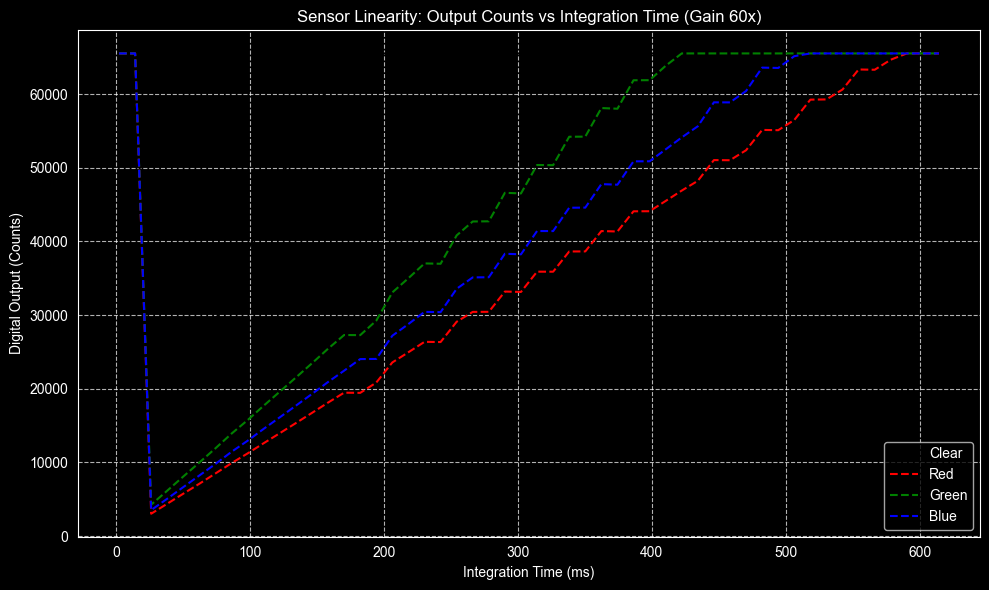

In [10]:
def test_and_plot_linearity():
    print("--- Test 1.0: Linearity Data Collection ---")
    
    # 1. SETUP
    write_register(ENABLE_REG, 0x03)   # Power + ADC Enable
    write_register(CONTROL_REG, 0x03)  # Gain = 60x (Max)
    
    # Lists to store data for plotting
    x_time_ms = []
    y_clear = []
    y_red = []
    y_green = []
    y_blue = []
    
    # 2. SWEEP LOOP (0 to 255)
    # We step by 5 to speed it up, but you can use step=1 for higher res
    for i in range(0, 256, 5): 
        atime_reg = 255 - i
        write_register(ATIME_REG, atime_reg)
        
        # Calculate Integration Time
        # Datasheet: Time = (256 - ATIME) * 2.4ms [cite: 314]
        integ_steps = 256 - atime_reg
        time_ms = integ_steps * 2.4
        
        # Wait for integration (+ buffer)
        time.sleep((time_ms / 1000.0) + 0.02)
        
        c = read_colors()
        if c:
            # Store data
            x_time_ms.append(time_ms)
            y_clear.append(c['clear'])
            y_red.append(c['red'])
            y_green.append(c['green'])
            y_blue.append(c['blue'])
            
            # Print minimal status
            print(f"Time: {time_ms:.1f}ms -> Clear: {c['clear']}")

    # 3. PLOTTING
    print("\nGenerating Plot...")
    plt.figure(figsize=(10, 6))
    
    plt.plot(x_time_ms, y_clear, 'k-', label='Clear', linewidth=1.5)
    plt.plot(x_time_ms, y_red,   'r--', label='Red')
    plt.plot(x_time_ms, y_green, 'g--', label='Green')
    plt.plot(x_time_ms, y_blue,  'b--', label='Blue')
    
    plt.title('Sensor Linearity: Output Counts vs Integration Time (Gain 60x)')
    plt.xlabel('Integration Time (ms)')
    plt.ylabel('Digital Output (Counts)')
    plt.grid(True, which='both', linestyle='--', alpha=0.7)
    plt.legend()
    
    plt.tight_layout()
    plt.show()

# Run the function
test_and_plot_linearity()